# 航空公司顾客满意度调查

## 简介

### 构建XGBoost分类模型。用于调查顾客对于航空公司服务内容评价，预测航空公司提供的哪几种服务最有可能影响顾客的满意度。

## 项目成果
(1) 模型性能

- 准确率（92.85%）：模型整体预测正确率较高，但需结合其他指标综合评估。

- 精确率（93.87%）：模型预测为“满意”的乘客中，93.87% 确实满意（误报率低）。

- 召回率（93.02%）：模型能捕捉到 93.02% 的真实满意乘客（漏报率低）。

- F1分数（93.44%）：精确率与召回率的平衡指标，表明模型在减少误判和漏判上表现优秀。

结论：模型性能优异，适合实际部署，但需持续监控业务场景中的误报（如将不满意乘客误判为满意）影响。

(2) 关键特征分析
影响乘客满意度的 Top 5 因素及其业务意义：

- 机上餐饮（71%影响）

 提供高质量餐食可显著提升满意度。

- 准时到达（49%影响）

 航班延误是主要不满来源，优化调度是关键。

- 旅行类型（43%影响）

 商务旅客满意度更高，建议为个人旅客提供差异化服务（如升舱优惠）。

- 机舱清洁度（40%影响）

 定期深度清洁机舱，避免卫生问题引发投诉。

- 座椅舒适度（40%影响）

 避免因降低成本牺牲座椅质量，否则可能损失长期客户。

业务建议：优先改进餐饮和准点率，同时关注机舱环境与座椅设计。

## 第一步：探索数据

### 1. 导入Python的`pandas`和`numpy`库

In [ ]:
import pandas as pd
import numpy as np

### 2. 加载数据集

In [ ]:
airline_data = pd.read_csv('Invistico_Airline.csv', on_bad_lines='skip')

### 3. 预览数据前5行

In [ ]:
airline_data.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


### 4. 显示每列的数据类型

In [ ]:
airline_data.dtypes

,0
satisfaction,object
Customer Type,object
Age,int64
Type of Travel,object
Class,object
Flight Distance,int64
Seat comfort,int64
Departure/Arrival time convenient,int64
Food and drink,int64
Gate location,int64


### 5. 统计有空值的行数，统计数据集总行数，统计有空值的行数占数据集总行数比例

In [ ]:
null_rows = airline_data.isnull().any(axis=1).sum()

total_rows = len(airline_data)

print(f"Total number of rows in dataset: {total_rows}")
print(f"Number of rows with null values: {null_rows}")
print(f"Null line proportion: {null_rows/total_rows:.2%}")

Total number of rows in dataset: 129880
Number of rows with null values: 393
Null line proportion: 0.30%


**问题:** 确定客户购买的目标(或预测)变量。关于哪些变量在预测满意度方面有价值，最初的假设是什么？

- ‘满意度’代表要预测的目标分类变量。
- 这些变量中的许多似乎是满意度的有意义的预测因素。特别是，延误(出发或到达)可能与满意度负相关。

## 第二步：模型准备

### 6. 删除具有空值的行，并重建索引

In [ ]:
airline_data_cleaned = airline_data.dropna()

airline_data_cleaned.reset_index(drop=True, inplace=True)

### 7. 创建ETL管道，过滤数据集`object`文本字符类型，用独热编码`One-Hot Encoding`，将分类变量转换为虚拟变量

重建列名，并打印预览前五列

- 在上边预览数据时，`满意度`、`客户类型`、`旅行类型`、`仓位类型`是`object`文本字符类别
- 每个类别值会被转换成新的二进制列（`0`或`1`）

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# 筛选 object 类型的列（分类变量）
categorical_cols = airline_data_cleaned.select_dtypes(include=['object']).columns.tolist()

# 设置 ColumnTransformer 输出为 pandas DataFrame
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
).set_output(transform="pandas") # 输出为 DataFrame

# 直接得到带列名的 DataFrame
airline_data_encoded_df = preprocessor.fit_transform(airline_data_cleaned)
airline_data_encoded_df.head()

,cat__satisfaction_satisfied,cat__Customer Type_disloyal Customer,cat__Type of Travel_Personal Travel,cat__Class_Eco,cat__Class_Eco Plus,remainder__Age,remainder__Flight Distance,remainder__Seat comfort,remainder__Departure/Arrival time convenient,remainder__Food and drink,...,remainder__Online support,remainder__Ease of Online booking,remainder__On-board service,remainder__Leg room service,remainder__Baggage handling,remainder__Checkin service,remainder__Cleanliness,remainder__Online boarding,remainder__Departure Delay in Minutes,remainder__Arrival Delay in Minutes
0,1.0,0.0,1.0,1.0,0.0,65,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,1.0,0.0,1.0,0.0,0.0,47,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,1.0,0.0,1.0,1.0,0.0,15,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,1.0,0.0,1.0,1.0,0.0,60,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,1.0,0.0,1.0,1.0,0.0,70,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


### 8. 定义目标变量和预测变量
分别定义目标变量(`满意度')和特征。

In [ ]:
# 从已编码的数据集中提取目标变量和预测变量（不修改原数据集）
y = airline_data_encoded_df['cat__satisfaction_satisfied'].copy()  # 目标变量
X = airline_data_encoded_df.drop(columns=['cat__satisfaction_satisfied']).copy()  # 预测变量

### 9. 分割数据

将数据分为训练集(75%的数据)和测试集(25%的数据)。保留模型尚未使用的一部分数据，以测试模型对新数据的概括(或执行)情况。

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## 第三步：建立模型

### 10. 创建了一个`XGBoost`分类器`XGBClassifier`实例

在将模型拟合到航空公司数据集之前，首先创建一个分类器实例将目标变量`cat__satisfaction_satisfied`（客户是否满意“是”或“否”）

二分类以解决损失函数和输出处理方式

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

### 11. 定义超参数调整的参数

要为`xgboost`模型确定合适的参数，首先定义超参数调整的参数。具体来说，考虑调整`max_depth`、`min_child_weight`、`learning_rate`、`n_estimators`、`subsample`和`colsample_bytree`。

- 超参数作用：

(1) max_depth：单棵树的最大深度（控制复杂度）

(2) min_child_weight：子节点所需的最小样本权重和

(3) learning_rate：学习率/收缩系数

(4) n_estimators：树的数量

(5) subsample：样本采样比例

(6) colsample_bytree：特征采样比例

考虑每个超参数更有限的范围，以便及时迭代和模型训练。例如，对上面列出的六个超参数中的每一个使用一个可能的值，在这个平台上运行大约需要一分钟。

```
{
    'max_depth': [4],
    'min_child_weight': [3],
    'learning_rate': [0.1],
    'n_estimators': [5],
    'subsample': [0.7],
    'colsample_bytree': [0.7]
}
```

In [ ]:
# 定义超参数，然后赋值给 `cv_params`.
cv_params = {'max_depth': [4, 6],
               'min_child_weight': [3, 5],
               'learning_rate': [0.1, 0.2, 0.3],
               'n_estimators': [5,10,15],
               'subsample': [0.7],
               'colsample_bytree': [0.7]
               }

**问题:**在你的网格搜索中增加更多的评估者可能会有什么影响？

- 更多的参数将最初提高模型的性能。然而，增加参数的数量也会大大增加网格搜索过程中所花费的时间，而且随着参数量的不断增加，收益也会减少。

### 12. 定义如何评估模型

定义如何评估超参数调整的模型。取值标准各项指标越接近`1`代表模型性能越好。

| 指标        | 公式                                   | 评判标准                                                                 |
|-------------|----------------------------------------|--------------------------------------------------------------------------|
| `accuracy`  | (TP+TN)/(TP+TN+FP+FN)                 | 当各类别重要性相同时使用，对类别平衡数据敏感                             |
| `precision` | TP/(TP+FP)                            | 关注预测为正类的准确性，适用于需要最小化误报（FP）的场景                 |
| `recall`    | TP/(TP+FN)                            | 关注正类样本的覆盖率，适用于需要最小化漏报（FN）的场景                   |
| `f1`        | 2×(precision×recall)/(precision+recall) | 平衡精确率和召回率，适用于类别不平衡数据或需要综合评估的场合             |

In [ ]:
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'accuracy': 'accuracy',
    'f1': 'f1'
}

### 13. 构建网格搜索交叉验证

1. 使用定义的`xgb`模型
2. 定义超参数搜索空间`cv_params`(上述代码已经定义范围)。
3. 评估指标集合
4. 交叉验证策略，5折表示数据分5份，4训1验重复5次
5. 模型选择标准，指定`f1`指标在验证集上的表现选择最优模型


In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_cv = GridSearchCV(estimator = xgb,
            param_grid = cv_params,
            scoring = scoring,
            cv = 5,
            refit = 'f1')

### 14. 让`GridSearch`网格搜索交叉验证训练测试数据集
**注意:**以下单元格可能需要几分钟时间来运行。

In [ ]:
%%time
xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: user 1min 40s, sys: 475 ms, total: 1min 41s
Wall time: 58.8 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

**问题:** `GridSearch`网格搜索交叉验证得出了哪一组最佳参数？

通过访问拟合网格搜索模型的“最佳参数”属性，超参数的最佳集合是:

```
{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7} ```

### 15. 使用`dump`保存模型以供参考

In [ ]:
from joblib import dump
dump(xgb_cv, 'xgb_cv.joblib')

['xgb_cv.joblib']

## 第四步：结果和评估

### 16. 在测试集上制定预测

要评估模型生成的预测，利用scikit-learn的一系列指标和评估技术，方法是检查测试集中与模型预测相关的实际观察值。

首先，使用训练好的模型在测试集`X_test`上制定预测。

In [ ]:
y_pred = xgb_cv.predict(X_test)

### 17. 利用指标来评估模型的性能

应用scikit-learn中的一系列指标来评估模型。打印与测试数据和预测值相关联的准确度分数、精确度分数、召回分数和f1分数。

**定义：**如何评估超参数调整的模型。取值标准各项指标越接近`1`代表模型性能越好。

In [ ]:
from sklearn import metrics
# 1. 打印准确度分数。
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

# 2. 打印精确分数。
pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

# 打印召回分数。
rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

# 4. 打印f1分数。
f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9284875818608674
precision score: 0.9386988445557516
recall score: 0.930174844895657
f1 score: 0.9344174055922264


**问题：**应该如何解释准确度分数？

- 这个模型的准确度分数是0.928，或92.85%的准确度。

**问题：**准确度分数是否足以评估模型？

- 在分类问题中，知道准确性是有用的，但可能不是评估该模型的最佳度量。

**问题:**当观察模型的精度和召回分数时，如何解释这些值，一个比另一个更准确吗？

- 精确度和召回分数都有助于评估模型的正确预测能力，因为它们平衡了预测中固有的假阳性和假阴性。该模型显示精度分数为0.939，表明该模型非常擅长预测真阳性。这意味着模型正确地预测了乘客是否会满意。0.930的召回分数也很不错。这意味着该模型在正确识别数据集中不满意的乘客方面做得很好。这两个度量结合起来比单独的准确性度量给出了更好的模型性能评估。

**问题：**除了其他指标提供的信息之外，F1分数还能代表什么？

- F1分数平衡了精确度和召回性能，以给出该模型提供预测的好坏的综合评估。在这种情况下，F1值为0.934，这表明该模型具有非常强的预测能力。

### 18. 通过混淆矩阵获得清晰性

**混淆矩阵**是一个图形，它显示了模型的真阳性和假阳性以及真阴性和假阴性。它有助于创建输入到上述指标中的组件的可视化表示。

根据测试集的预测值创建混淆矩阵。

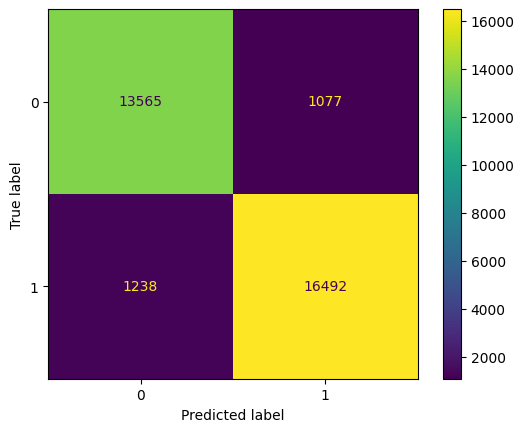

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)

disp.plot()

**（1）问题：**当观察混淆矩阵时，应该注意什么？这和其他计算有关联吗？

- 关键数值解析
True Negative (TN)：13,565
真实为负类（0）且预测正确的样本数。

- False Positive (FP)：1,077
真实为负类（0）但误判为正类（1）的样本数（误报）。

- False Negative (FN)：1,238
真实为正类（1）但误判为负类（0）的样本数（漏报）。

- True Positive (TP)：16,492
真实为正类（1）且预测正确的样本数。

**（2）问题：**模型表现分析

- 整体准确率较高（90.8%），模型对正负类的预测能力较均衡。

- 精确率（93.9%）和召回率（93.0%）均表现优秀，说明模型在减少误报和漏报上表现良好。

### 19. 影响模型最重要的特征

使用`xgboost`的内置函数，使用`matplotlib`来可视化模型中各特征的相对重要性。输出并检查模型的特征重要性。

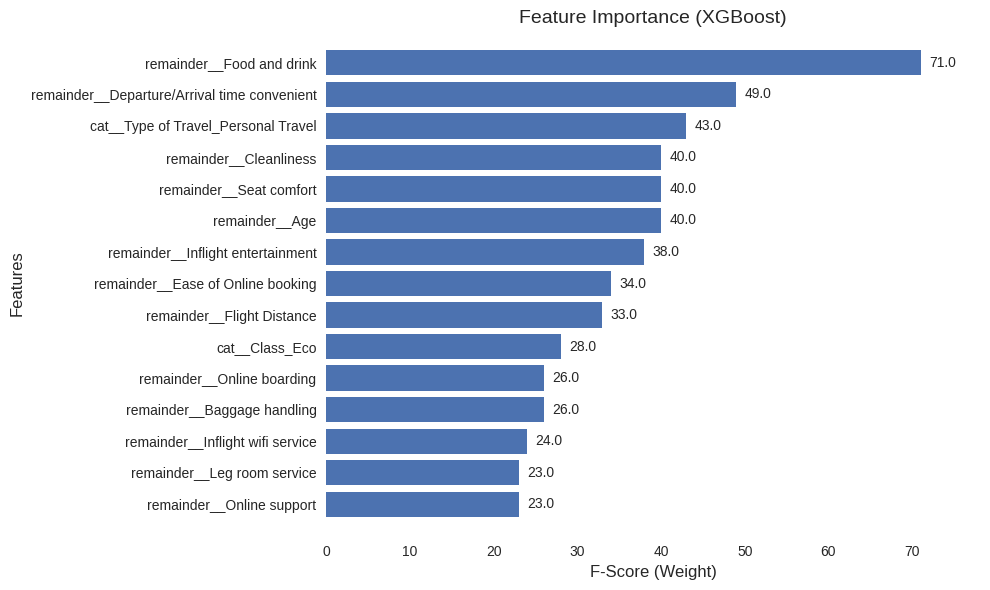

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# 设置图表风格
plt.style.use('seaborn-v0_8')  # 或 'seaborn-whitegrid', 'ggplot'

# 绘制特征重要性
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(
    xgb_cv.best_estimator_,
    ax=ax,
    importance_type='weight',
    max_num_features=15,
    height=0.8,
    title='Feature Importance (XGBoost)',
    xlabel='F-Score (Weight)',
    ylabel='Features',
    grid=False
)

# 自定义颜色和字体
ax.set_facecolor('white')
ax.title.set_fontsize(14)
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)

# 保存高清图片
plt.tight_layout()
plt.show()

**问题：**检查上面输出的特性重要性。对结果的评价是什么？

- 在该机型中，影响顾客满意度最主要前五项因素是：
1. 飞机上的食物和饮料。对顾客满意度影响水平达到71%
2. 出发后的到达时间，到达时间越早乘客越感到满意。对顾客满意度影响水平达到49%。
3. 商务旅行和个人旅行，商务旅行更可能满意，因为商务顾客会乘坐较为舒适和高服务水平的商务舱。对顾客满意度影响水平达到43%。
4. 机舱的清洁度也很重要。谁也不会想坐在杂物满地和有异味的机仓进行旅途。对顾客满意度影响水平达到40%。
5. 座椅的舒适度也是顾客的重要考量，如果为了节省成本而更换座椅可能会因小失大。对顾客满意度影响水平达到40%。



### 20. 新数据集调用已完成`xgb_cv`模型

In [ ]:
# 1. 利用preprocessor管道预处理新数据
new_data_encoded = preprocessor.transform(new_data_cleaned)

# 2. 模型预测
predictions = xgb_cv.predict(new_data_encoded)